Enter the states (or US, all, increasing, decreasing) that you would like to graph (AK,TN,US):
increasing

Would you like unsmoothed data, 7-day SMA, or both? (default unsmoothed)
sma

Weekly increase in cases by state:
DE: 64.93%
ID: 53.54%
TN: 46.17%
CA: 43.22%
WA: 39.88%
OR: 36.23%
LA: 35.14%
AZ: 34.90%
WI: 33.88%
SC: 31.77%
GA: 30.83%
OK: 30.79%
FL: 30.31%
MI: 28.16%
OH: 27.29%
NJ: 25.96%
TX: 24.75%
KS: 24.27%
KY: 21.93%
IN: 19.58%
NM: 18.40%
AL: 15.67%
NV: 15.05%
PA: 13.79%
NC: 11.80%
MS: 9.58%
VA: 6.83%
NY: 6.24%


<IPython.core.display.Javascript object>


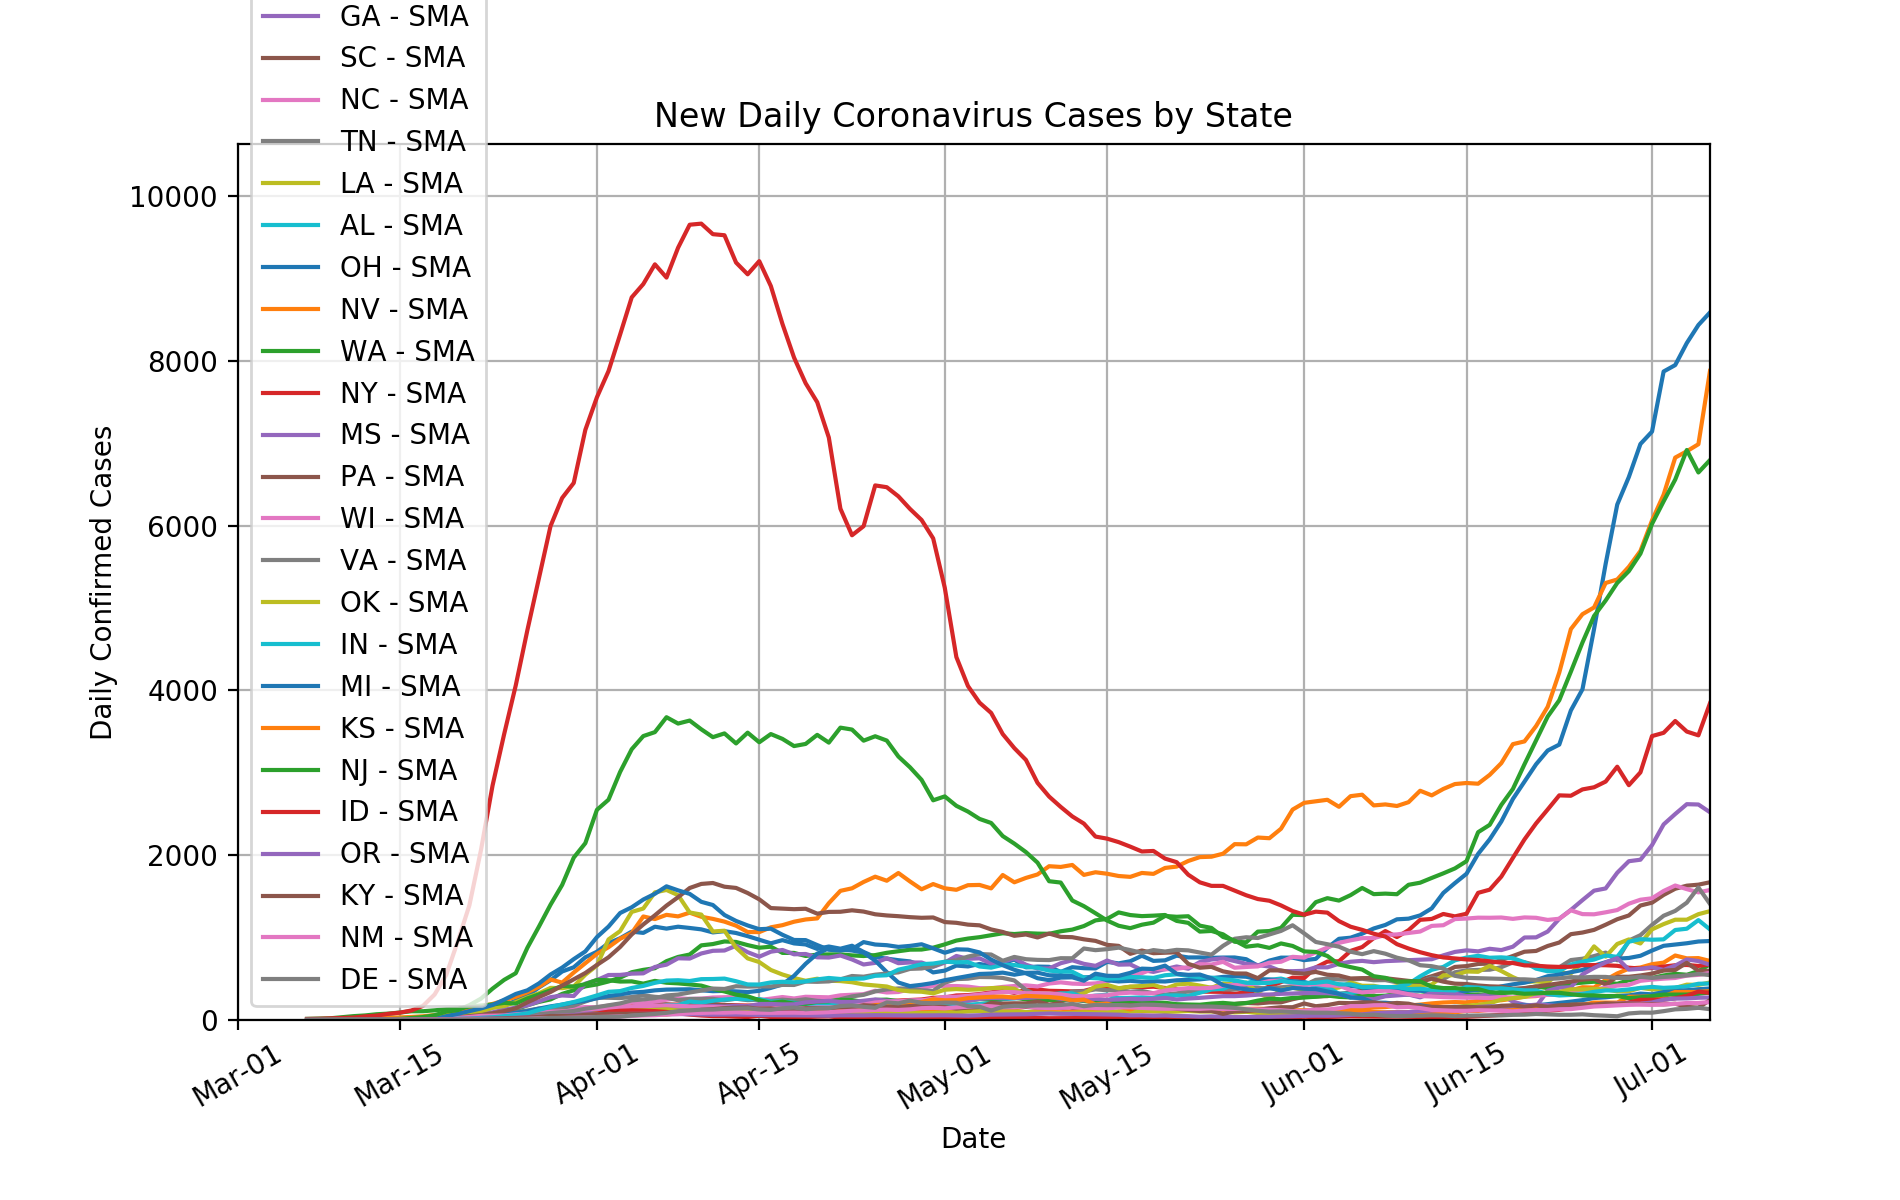

In [2]:
import csv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from datetime import datetime 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from useful_lists import state_list
from statistics import mean

mpl.rcParams['date.autoformatter.month'] = '%b-%Y'
mpl.rcParams['date.autoformatter.day'] = '%b-%d'

%matplotlib notebook

#read in CSV data
data = pd.read_csv('COVID_state_data.csv')

#calculate SMA and create datetime objects in list
SMA = data.rolling( window=7).mean()
date_list = [datetime.strptime(date, '%m/%d/%Y') for date in data['Date']]


#get user input (error detection)
while True:
    try:
        user_states = input('Enter the states (or US, all, increasing, decreasing) that you would like to graph (AK,TN,US):\n')
        user_states = user_states.split(',')
        user_states = [i.strip().upper() for i in user_states]
        for i in user_states:
            if i not in state_list and i not in ['US','ALL','INCREASING','DECREASING']:
                raise ValueError
        break
    except:
        print('Error: Invalid state\n')


while True:
    graphing_option = input('\nWould you like unsmoothed data, 7-day SMA, or both? (default unsmoothed)\n')
    if len(graphing_option) < 1 : graphing_option = 'unsmoothed data'
    graphing_option = graphing_option.upper().strip()
    if graphing_option not in ['UNSMOOTHED DATA','SMA','BOTH']:
        print('Error: Invalid graphing option\n')
    else: break

states_dict = {}
if user_states == ['INCREASING']:        
    user_states = []
    for state in state_list:
        if mean(data[state].tail(7)) > mean(data[state].tail(14).head(7))*1.05\
        and mean(data[state].tail(7)) > 50\
        and mean(data[state].tail(7)) - mean(data[state].tail(14).head(7)) > 25:
            percent = ((mean(data[state].tail(7))/mean(data[state].tail(14).head(7)))-1)*100
            states_dict[state] = percent
        else:
            continue
    print('\nWeekly increase in cases by state:')
    for state in sorted(states_dict, key=states_dict.get, reverse=True):
        user_states.append(state)
        print('{}: {:.2f}%'.format(state, states_dict[state]))  

if user_states == ['DECREASING']:        
    user_states = []
    for state in state_list:
        if mean(data[state].tail(7)) < mean(data[state].tail(14).head(7))*.95\
        and mean(data[state].tail(14).head(7)) > 50\
        and mean(data[state].tail(7)) - mean(data[state].tail(14).head(7)) < -25:
            percent = ((mean(data[state].tail(7))/mean(data[state].tail(14).head(7)))-1)*100
            states_dict[state] = percent
        else:
            continue
    print('\nWeekly decrease in cases by state:')
    for state in sorted(states_dict, key=states_dict.get):
        user_states.append(state)
        print('{}: {:.2f}%'.format(state, states_dict[state]))
                        
if user_states == ['ALL']:
    user_states = [i for i in state_list]

#calculate y range for setting ylim
if graphing_option == 'SMA':
    abs_max = max([np.nanmax(SMA[state]) for state in user_states])
else: 
    abs_max = max([max(data[state]) for state in user_states])

#customize plot
plt.figure(figsize = (9.5,6))
plt.subplots_adjust(bottom = .15)
ax = plt.axes()
plt.ylim(0,abs_max*1.1)
plt.xlim(date_list[0],date_list[-1])
plt.xticks(rotation=30)
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)
plt.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Daily Confirmed Cases')
ax.set_title('New Daily Coronavirus Cases by State')

#plot correct data based on user input
if graphing_option == 'UNSMOOTHED DATA':
    for state in user_states:
        states_dict[state]=float(data[state].tail(1))
    for state in sorted(states_dict, key=states_dict.get, reverse=True):
        plt.plot(date_list,data[state],label= state)

elif graphing_option == 'SMA':
    for state in user_states:
        states_dict[state]=float(SMA[state].tail(1))
    for state in sorted(states_dict, key=states_dict.get, reverse=True):
        plt.plot(date_list,SMA[state],label=state+' - SMA')

elif graphing_option == 'BOTH':
    for state in user_states:
        states_dict[state]=float(SMA[state].tail(1))
    for state in sorted(states_dict, key=states_dict.get, reverse=True):
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(date_list,data[state],label= state + ' -SMA-', color = color)
        plt.plot(date_list,SMA[state],color = color, linestyle = '--')

plt.legend()


In [3]:
states_dict = {}
for state in state_list:
    percent = ((mean(data[state].tail(7))/mean(data[state].tail(14).head(7)))-1)*100
    states_dict[state] = percent
us_case_change = int(float(SMA['US'].tail(1))-float(SMA['US'].tail(8).head(1)))


#find and count decreasing states 
decreasing_states_count = 0
for state in state_list:
    if mean(data[state].tail(7)) < mean(data[state].tail(14).head(7))*.95\
    and mean(data[state].tail(14).head(7)) > 50\
    and mean(data[state].tail(7)) - mean(data[state].tail(14).head(7)) < -25:
        decreasing_states_count += 1
    else:
        continue

#find and count increasing states 
increasing_states_count = 0
for state in state_list:
    if mean(data[state].tail(7)) > mean(data[state].tail(14).head(7))*1.05\
    and mean(data[state].tail(7)) > 50\
    and mean(data[state].tail(7)) - mean(data[state].tail(14).head(7)) > 25:
        increasing_states_count += 1
    else:
        continue

print('   WEEKLY CHANGE IN CASES PER DAY',us_case_change,"         increasing states: {}    decreasing states: {}"\
.format(increasing_states_count, decreasing_states_count))
print('-'*38)
print('State:  Percent change   Cases per day')
print('-'*38)
for state in sorted(states_dict, key=states_dict.get, reverse=True):
    percent = '{:.2f}%'.format(states_dict[state])
    case_change = int(float(SMA[state].tail(1))-float(SMA[state].tail(8).head(1)))
    if states_dict[state]>0:
        print('{}:        {percent:<7}             {cases:<5}'\
                  .format(state, percent=percent, cases = case_change))
    
    else:
        if case_change == 0:
            print('{}:       {percent:<7}              {cases:<5}'\
                  .format(state, percent=percent, cases = case_change))
        else: 
            print('{}:       {percent:<7}             {cases:<5}'\
                  .format(state, percent=percent, cases = case_change))
            

   WEEKLY CHANGE IN CASES PER DAY 10406          increasing states: 28    decreasing states: 0
--------------------------------------
State:  Percent change   Cases per day
--------------------------------------
AK:        83.22%              17   
MT:        78.38%              20   
DE:        64.93%              51   
HI:        54.76%              6    
ID:        53.54%              114  
WV:        52.83%              24   
TN:        46.17%              444  
CA:        43.22%              2376 
WA:        39.88%              192  
ND:        37.17%              12   
OR:        36.23%              72   
LA:        35.14%              343  
AZ:        34.90%              994  
WI:        33.88%              144  
SC:        31.77%              403  
GA:        30.83%              594  
OK:        30.79%              107  
FL:        30.31%              1997 
MI:        28.16%              84   
OH:        27.29%              205  
NJ:        25.96%              68   
TX:        